In [3]:
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
import sys
import os
sys.path.append(os.path.abspath('helperPix2Pix'))
from generator_model import Generator
from discriminator_model import Discriminator
from trainPix2Pix import train_fn, validate_fn

import config
from dataset import MapDataset

from torch.utils.data import DataLoader
from tqdm import tqdm
import h5py
import random
from scipy.io import savemat

In [4]:
sys.path.append(os.path.abspath(os.path.join('..', '..', 'helper')))

import loader
import utils
import plotfig

In [5]:
# Configuration
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

BATCH_SIZE = 32 #64  # Batch size
NUM_EPOCHS = 20

# rows from DeepMIMO dataset settings
# change rows according to the .mat dataset file 
rows = [['3500', '3516']] 
fc = '3p4' #Hz can change to '60'
rowss = "3500_3516"
outer_file_path = os.path.abspath(os.path.join('..', '..', '..',
                                                'DeepMIMOv2', 'DeepMIMO_Data', 'Static_BS16', 'freq_symb_1ant_612sub_ver4'))


In [6]:
SNR = np.arange(-25, 31, 5)
snr = 0
fc = '3p4'
lr = 2e-4

norm_approach = 'minmax' # can be set to 'std'
lower_range = -1 
    # if norm_approach = 'minmax': 
        # =  0 for scaling to  [0 1]
        # = -1 for scaling to [-1 1]
    # if norm_approach = 'std': can be any value, but need to be defined
    
if norm_approach == 'minmax':
    if lower_range == 0:
        norm_txt = 'Using min-max [0 1]'
    elif lower_range ==-1:
        norm_txt = 'Using min-max [-1 1]'
elif norm_approach == 'no':
    norm_txt = 'No'
    
# create readme.txt file
content = f"""Generated by file 'train/Pix2Pix/Pix2Pix_v2_(...).ipynb'.
Correspond with BS16, 3.4 GHz fc, rows {rowss},
Data got from {outer_file_path},
Learning rate {lr}, {NUM_EPOCHS} epochs
{norm_txt} scaler for each sample
"""

# Paths to save
idx_save_path = loader.find_incremental_filename('../../model/static/GAN/BS16/'+ rowss,'ver', '_', '')
model_path = '../../model/static/GAN/BS16/' + rowss + '/ver' + str(idx_save_path) + '_/readme.txt'
figure_path = '../../figure/static/GAN/BS16/' + rowss + '/ver' + str(idx_save_path) + '_/readme.txt'

if not os.path.exists(os.path.dirname(model_path)):
    os.makedirs(os.path.dirname(model_path))
if not os.path.exists(os.path.dirname(figure_path)):
    os.makedirs(os.path.dirname(figure_path))

# Open the file in write mode ('w'). If the file does not exist, it will be created.
with open(model_path, 'w') as file:
    # Write the content to the file
    file.write(content)

with open(figure_path, 'w') as file:
    # Write the content to the file
    file.write(content)
    
print(f"File '{model_path}' and ' {figure_path} ' created and content written.")

save_folder_model = os.path.join('../../model/static/GAN', 'BS16', rowss, 'ver' + str(idx_save_path) + '_')
save_folder_fig = os.path.join('../../figure', 'static', 'GAN', 'BS16' ,  rowss, 'ver' + str(idx_save_path) +'_')


File '../../model/static/GAN/BS16/3500_3516/ver11_/readme.txt' and ' ../../figure/static/GAN/BS16/3500_3516/ver11_/readme.txt ' created and content written.


In [7]:
disc = Discriminator(in_channels=1).to(device)
gen = Generator(in_channels=1, features=64).to(device)
opt_disc = optim.Adam(disc.parameters(), lr=lr, betas=(0.5, 0.999))
opt_gen = optim.Adam(gen.parameters(), lr=lr, betas=(0.5, 0.999))
BCE = nn.BCEWithLogitsLoss()
L1_LOSS = nn.L1Loss()


/home/thien/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [8]:

nmse_LS_LI_val   = []
nmse_LS_GAN_val   = []
nmse_LI_GAN_val   = []

for snr in SNR:
    print(f" SNR: {snr}/{SNR[-1]}")
    variables = {}

    [trainLabels, valLabels], [H_equal_train, H_linear_train, H_practical_train], [H_equal_val, H_linear_val, H_practical_val] = loader.load_data(outer_file_path, rows, fc, device, snr)

    # -----------------------------------------------------
    for model_mode in ['LS_LI_GAN', 'LS_GAN']:
        print(f"{model_mode}")
        if model_mode == 'LS_LI_GAN':
            # [samples, 2, 612, 14]
            train_loader, trainLabel_min, trainLabel_max = loader.genLoader(H_linear_train, trainLabels, BATCH_SIZE, device, 'train', True, norm_approach, lower_range=lower_range)
                # train_loader = TensorDataset(data_normd, label_normd, label_x, label_y)
                # data_normd == 612 x 14 x (Nsamples*2)
            val_loader,     valLabel_min,   valLabel_max = loader.genLoader(H_linear_val,     valLabels, BATCH_SIZE, device, 'valid', False, norm_approach, lower_range=lower_range)
                # no shuffle in validation so valLabel_min and valLable_max remain the min and max arrays
                                                                                            # of valLabels
                # train_loader, val_loader are already normalized by their own min, max
                # "train" mode: treat real and image parts as 2 discrete images
        elif model_mode == 'LS_GAN':
            # [samples, 2, 612, 14]
            train_loader, trainLabel_min, trainLabel_max = loader.genLoader(H_equal_train, trainLabels, BATCH_SIZE, device, 'train', True, norm_approach, lower_range=lower_range)
                # train_loader = TensorDataset(data_normd, label_normd, label_x, label_y)
                # data_normd == 612 x 14 x (Nsamples*2)
            val_loader,     valLabel_min,   valLabel_max = loader.genLoader(H_equal_val,     valLabels, BATCH_SIZE, device, 'valid', False, norm_approach, lower_range=lower_range)
                # no shuffle in validation so valLabel_min and valLable_max remain the min and max arrays
                                                                                            # of valLabels
                # train_loader, val_loader are already normalized by their own min, max
                # "train" mode: treat real and image parts as 2 discrete images
        
        # 1.5 Training loop
        train_loss =[]
        train_Dloss = []
        nmse_gen = []
        mse_gen = []
        val_loss = []  # over epochs
        H_GAN_val = torch.empty_like(valLabels) # [nVal, 2, 612, 14]
        min_H_true = []
        max_H_true = []

        #### train model
        for epoch in range(NUM_EPOCHS):
            print(f'Epoch: {epoch}/{NUM_EPOCHS}: ')

            flag_last_epoch = (epoch == NUM_EPOCHS-1) # last epoch
            train_loss_iEpoc, train_D_loss_iEpoc, mse_gen_iEpoc, nmse_gen_iEpoc = train_fn(disc, gen,
                                                                            train_loader, opt_disc, opt_gen, 
                                                                            L1_LOSS, BCE, return_mse=True, return_nmse=True)
            
            # Validation step
            if flag_last_epoch==True:
                val_loss_iEpoc, H_GAN_val = validate_fn(gen, val_loader, L1_LOSS, BCE, flag_last_epoch)
            else:
                val_loss_iEpoc = validate_fn(gen, val_loader, L1_LOSS, BCE, flag_last_epoch)

            train_loss.append(train_loss_iEpoc)  
            train_Dloss.append(train_D_loss_iEpoc)  
            val_loss.append(val_loss_iEpoc)
            mse_gen.append(mse_gen_iEpoc)
            nmse_gen.append(nmse_gen_iEpoc)
            
            # level over epochs
        # end for epoch
        # level of  model_mode in ['LS_LI_GAN', 'LS_GAN']
        save_folder = os.path.join(save_folder_model, str(snr)+'dB')
        os.makedirs(save_folder, exist_ok=True)
        index_save = loader.find_incremental_filename(save_folder, 'GAN_', '_variable')

        modelG_save_path = os.path.join(save_folder,  'G_' +str(index_save)+'_' + model_mode +'_model.pth')
        modelD_save_path = os.path.join(save_folder,  'D_' +str(index_save)+'_' + model_mode +'_model.pth')
        variable_save_path = os.path.join(save_folder, 'GAN_' +str(index_save)+'_variable.mat')

        variables['MSE_gen']  = mse_gen
        variables['NMSE_gen'] = nmse_gen
        if model_mode=='LS_LI_GAN': 
            variables['G_train_track_LS_LI_GAN'] = train_loss
            variables['D_train_track_LS_LI_GAN'] = train_Dloss
            variables['G_val_track_LS_LI_GAN']   = val_loss
        elif model_mode== 'LS_GAN':
            variables['G_train_track_LS_GAN'] = train_loss
            variables['D_train_track_LS_GAN'] = train_Dloss
            variables['G_val_track_LS_GAN']   = val_loss
            
        torch.save({
        'model_state_dict': gen.state_dict(),
        'optimizer_state_dict': opt_gen.state_dict()
        }, modelG_save_path)
        
        torch.save({
        'model_state_dict': disc.state_dict(),
        'optimizer_state_dict': opt_disc.state_dict()
        }, modelD_save_path)
        
        savemat(variable_save_path, variables)
        
        os.makedirs(save_folder, exist_ok=True)

        plotfig.figLoss(train_loss, val_loss, index_save, save_folder, '_'+model_mode+'_Loss.png')

        ######
        
        valLabels_complex = valLabels.cpu()
        valLabels_complex = torch.complex(valLabels_complex[:,0,:,:], valLabels_complex[:,1,:,:]) # [?, 612, 14]
        
        # denormalize H_GAN_val
        H_GAN_val_denormd = utils.deMinMax(H_GAN_val, valLabel_min, valLabel_max, lower_range=-1)
        H_GAN_val_denormd = H_GAN_val_denormd.cpu()
        H_GAN_val_denormd_complex = torch.complex(H_GAN_val_denormd[:,0,:,:], H_GAN_val_denormd[:,1,:,:]) # [?, 612, 14]
        
        nmse_GAN_iSNR = utils.calNMSE(H_GAN_val_denormd_complex, valLabels_complex) # array
        avg_nmse_GAN_iSNR = nmse_GAN_iSNR.mean()
        
        if model_mode == 'LS_LI_GAN':
            nmse_LI_GAN_val.append(avg_nmse_GAN_iSNR.item())
            plotfig.figPredChan(H_GAN_val_denormd[-1,0,:,:], 'LS+LI+GAN Estimated Channel',
                                    nmse_GAN_iSNR[-1], 1, save_folder, '_LS_LI_GAN_estimatedChan.png')
                                # save_folder = f'model/static/GAN/ver{idx_save_path}_/{snr}dB'
    
            
            #####
            # NMSE of Linear Interpolation   # just need to calculate this 1 time  --> calculate at case model_name == 'LS_LI_GAN'
            H_val_linInterp = H_linear_val.cpu()
            # convert to complex matrices
            H_val_linInterp_complex = torch.complex(H_val_linInterp[:,0,:,:], H_val_linInterp[:,1,:,:]) # [?, 612, 14]
            nmse_LI = utils.calNMSE(H_val_linInterp_complex, valLabels_complex)
            
            nmse_LS_LI_val.append(nmse_LI.cpu().mean())
            print(f"LS+LI NMSE: {nmse_LI.cpu().mean()}")
            
            plotfig.figPredChan(H_val_linInterp[-1,0,:,:], 'LS + Interpolate Estimated Channel',
                                    nmse_LI[-1], 1, save_folder, '_LS_LI_estimatedChan.png')
                            # save_folder = f'model/static/GAN/ver{idx_save_path}_/{snr}dB'
            
            ##########
        elif model_mode == 'LS_GAN':
            nmse_LS_GAN_val.append(avg_nmse_GAN_iSNR.item())
            plotfig.figPredChan(H_GAN_val_denormd[-1,0,:,:], 'LS+GAN Estimated Channel',
                                    nmse_GAN_iSNR[-1], 1, save_folder, '_LS_GAN_estimatedChan.png')
                                # save_folder = f'model/static/GAN/ver{idx_save_path}_/{snr}dB'
        
    # end for model_mode in ['LS_LI_GAN', 'LS_GAN'] 
# end for SNR
savemat(save_folder_model+'/nmse.mat', {'nmse_LS_LI_val':nmse_LS_LI_val, 'nmse_LS_GAN_val':nmse_LS_GAN_val, 
                                        'nmse_LI_GAN_val':nmse_LI_GAN_val})
print(f'Successfully save files at {save_folder_model}')

 SNR: -25/30
LS_LI_GAN
Epoch: 0/20: 


100%|██████████| 173/173 [00:20<00:00,  8.49it/s, D_fake=0.0619, D_real=0.918]


Training Generator Loss: 34.3072
Validation Loss: 24.8033
Epoch: 1/20: 


100%|██████████| 173/173 [00:17<00:00,  9.89it/s, D_fake=0.0022, D_real=0.999] 


Training Generator Loss: 27.5051
Validation Loss: 22.9334
Epoch: 2/20: 


100%|██████████| 173/173 [00:17<00:00,  9.74it/s, D_fake=0.456, D_real=0.534]  


Training Generator Loss: 25.5623
Validation Loss: 20.8841
Epoch: 3/20: 


100%|██████████| 173/173 [00:17<00:00,  9.72it/s, D_fake=0.475, D_real=0.551]


Training Generator Loss: 20.5930
Validation Loss: 20.0960
Epoch: 4/20: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=0.131, D_real=0.668]


Training Generator Loss: 20.2871
Validation Loss: 19.7214
Epoch: 5/20: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.00255, D_real=0.999]


Training Generator Loss: 22.9507
Validation Loss: 19.9541
Epoch: 6/20: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.00634, D_real=0.999] 


Training Generator Loss: 25.0525
Validation Loss: 19.8992
Epoch: 7/20: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.469, D_real=0.506]   


Training Generator Loss: 22.2292
Validation Loss: 18.8644
Epoch: 8/20: 


100%|██████████| 173/173 [00:18<00:00,  9.55it/s, D_fake=0.006, D_real=0.998]  


Training Generator Loss: 20.6188
Validation Loss: 19.8140
Epoch: 9/20: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.0123, D_real=0.999] 


Training Generator Loss: 23.0433
Validation Loss: 19.0180
Epoch: 10/20: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.00196, D_real=0.999] 


Training Generator Loss: 23.8528
Validation Loss: 19.7687
Epoch: 11/20: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.0014, D_real=0.999]  


Training Generator Loss: 23.9329
Validation Loss: 20.3160
Epoch: 12/20: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.00038, D_real=1]     


Training Generator Loss: 23.9150
Validation Loss: 19.7877
Epoch: 13/20: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.00113, D_real=0.999] 


Training Generator Loss: 23.8123
Validation Loss: 19.7955
Epoch: 14/20: 


100%|██████████| 173/173 [00:18<00:00,  9.52it/s, D_fake=0.475, D_real=0.485]  


Training Generator Loss: 17.5152
Validation Loss: 19.3903
Epoch: 15/20: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.432, D_real=0.571]


Training Generator Loss: 15.3991
Validation Loss: 20.0498
Epoch: 16/20: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.46, D_real=0.531] 


Training Generator Loss: 14.8651
Validation Loss: 19.7125
Epoch: 17/20: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.519, D_real=0.468]


Training Generator Loss: 14.3719
Validation Loss: 19.4564
Epoch: 18/20: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.00226, D_real=0.998]


Training Generator Loss: 16.5668
Validation Loss: 20.0649
Epoch: 19/20: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=0.000526, D_real=0.999]


Training Generator Loss: 20.2734
Validation Loss: 20.2517
LS+LI NMSE: 25.906044006347656
LS_GAN
Epoch: 0/20: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.00257, D_real=0.979]  


Training Generator Loss: 22.2991
Validation Loss: 20.1856
Epoch: 1/20: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00142, D_real=0.998] 


Training Generator Loss: 21.8737
Validation Loss: 19.0918
Epoch: 2/20: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.107, D_real=0.876]   


Training Generator Loss: 21.1140
Validation Loss: 19.2868
Epoch: 3/20: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.00992, D_real=0.994]


Training Generator Loss: 17.2964
Validation Loss: 19.0265
Epoch: 4/20: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=0.0605, D_real=0.954] 


Training Generator Loss: 18.0378
Validation Loss: 19.0387
Epoch: 5/20: 


100%|██████████| 173/173 [00:18<00:00,  9.57it/s, D_fake=0.00705, D_real=0.998]


Training Generator Loss: 17.2956
Validation Loss: 19.3682
Epoch: 6/20: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.00144, D_real=0.999] 


Training Generator Loss: 18.4056
Validation Loss: 19.5161
Epoch: 7/20: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.00565, D_real=0.999] 


Training Generator Loss: 18.4021
Validation Loss: 19.4631
Epoch: 8/20: 


100%|██████████| 173/173 [00:18<00:00,  9.57it/s, D_fake=0.000533, D_real=0.999]


Training Generator Loss: 18.3282
Validation Loss: 19.5515
Epoch: 9/20: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.000854, D_real=0.999]


Training Generator Loss: 18.0341
Validation Loss: 19.8884
Epoch: 10/20: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000187, D_real=0.999]


Training Generator Loss: 17.5774
Validation Loss: 19.8996
Epoch: 11/20: 


100%|██████████| 173/173 [00:18<00:00,  9.57it/s, D_fake=0.00589, D_real=0.998] 


Training Generator Loss: 14.5006
Validation Loss: 19.6294
Epoch: 12/20: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.000567, D_real=0.999]


Training Generator Loss: 16.3289
Validation Loss: 19.7563
Epoch: 13/20: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=0.00171, D_real=0.998]


Training Generator Loss: 12.5560
Validation Loss: 19.3405
Epoch: 14/20: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.00538, D_real=0.998]


Training Generator Loss: 13.3598
Validation Loss: 19.7703
Epoch: 15/20: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.0015, D_real=0.993] 


Training Generator Loss: 13.9161
Validation Loss: 19.4684
Epoch: 16/20: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.00191, D_real=0.999] 


Training Generator Loss: 14.6226
Validation Loss: 19.6070
Epoch: 17/20: 


100%|██████████| 173/173 [00:18<00:00,  9.52it/s, D_fake=0.0153, D_real=0.994] 


Training Generator Loss: 10.2431
Validation Loss: 19.5481
Epoch: 18/20: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.276, D_real=0.699]  


Training Generator Loss: 12.9813
Validation Loss: 19.5366
Epoch: 19/20: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.0211, D_real=0.993]  


Training Generator Loss: 12.8243
Validation Loss: 19.5140
 SNR: -20/30
LS_LI_GAN
Epoch: 0/20: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=0.0823, D_real=0.939]  


Training Generator Loss: 15.5162
Validation Loss: 9.2548
Epoch: 1/20: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.0064, D_real=0.997] 


Training Generator Loss: 10.9854
Validation Loss: 8.2820
Epoch: 2/20: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.00469, D_real=0.999] 


Training Generator Loss: 15.6672
Validation Loss: 8.5585
Epoch: 3/20: 


100%|██████████| 173/173 [00:18<00:00,  9.56it/s, D_fake=0.0214, D_real=0.997]  


Training Generator Loss: 14.1857
Validation Loss: 8.6275
Epoch: 4/20: 


100%|██████████| 173/173 [00:18<00:00,  9.57it/s, D_fake=0.0119, D_real=0.997] 


Training Generator Loss: 10.1101
Validation Loss: 8.6838
Epoch: 5/20: 


100%|██████████| 173/173 [00:18<00:00,  9.56it/s, D_fake=0.382, D_real=0.483]  


Training Generator Loss: 10.6537
Validation Loss: 8.2442
Epoch: 6/20: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.073, D_real=0.984] 


Training Generator Loss: 8.8493
Validation Loss: 8.4620
Epoch: 7/20: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.00842, D_real=0.997]


Training Generator Loss: 10.8181
Validation Loss: 8.5716
Epoch: 8/20: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.0075, D_real=0.996]  


Training Generator Loss: 12.7652
Validation Loss: 11.2241
Epoch: 9/20: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=0.0006, D_real=0.999]  


Training Generator Loss: 15.1335
Validation Loss: 8.4663
Epoch: 10/20: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.00011, D_real=0.999] 


Training Generator Loss: 13.9410
Validation Loss: 9.0033
Epoch: 11/20: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.000188, D_real=1]    


Training Generator Loss: 14.0533
Validation Loss: 8.6746
Epoch: 12/20: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.000239, D_real=0.999]


Training Generator Loss: 14.0217
Validation Loss: 9.4491
Epoch: 13/20: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=7.46e-5, D_real=0.999] 


Training Generator Loss: 14.2551
Validation Loss: 8.9767
Epoch: 14/20: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=5.98e-5, D_real=1]    


Training Generator Loss: 14.5060
Validation Loss: 8.6953
Epoch: 15/20: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.276, D_real=0.679]


Training Generator Loss: 7.3901
Validation Loss: 8.5579
Epoch: 16/20: 


100%|██████████| 173/173 [00:18<00:00,  9.55it/s, D_fake=0.474, D_real=0.553]


Training Generator Loss: 5.7436
Validation Loss: 8.3863
Epoch: 17/20: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.184, D_real=0.858]


Training Generator Loss: 5.9123
Validation Loss: 8.5313
Epoch: 18/20: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.19, D_real=0.087]   


Training Generator Loss: 8.4825
Validation Loss: 8.6474
Epoch: 19/20: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.000605, D_real=0.997]


Training Generator Loss: 10.7496
Validation Loss: 8.9639
LS+LI NMSE: 8.149526596069336
LS_GAN
Epoch: 0/20: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=4.95e-6, D_real=0.999]


Training Generator Loss: 13.2995
Validation Loss: 9.1141
Epoch: 1/20: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=4.46e-5, D_real=1]     


Training Generator Loss: 15.9143
Validation Loss: 8.7821
Epoch: 2/20: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=0.00209, D_real=0.991] 


Training Generator Loss: 11.8380
Validation Loss: 8.1957
Epoch: 3/20: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=0.00119, D_real=0.998]


Training Generator Loss: 10.6417
Validation Loss: 8.4391
Epoch: 4/20: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.0075, D_real=0.988] 


Training Generator Loss: 10.2908
Validation Loss: 8.0024
Epoch: 5/20: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.00919, D_real=0.998]


Training Generator Loss: 11.1919
Validation Loss: 11.0242
Epoch: 6/20: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.00274, D_real=0.999]


Training Generator Loss: 15.3067
Validation Loss: 10.9122
Epoch: 7/20: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=0.00181, D_real=0.999] 


Training Generator Loss: 18.6483
Validation Loss: 17.0978
Epoch: 8/20: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=0.0048, D_real=0.997]   


Training Generator Loss: 19.2352
Validation Loss: 8.9178
Epoch: 9/20: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.0122, D_real=0.991] 


Training Generator Loss: 9.9867
Validation Loss: 8.5034
Epoch: 10/20: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.00167, D_real=0.999] 


Training Generator Loss: 10.9974
Validation Loss: 8.4659
Epoch: 11/20: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=0.000234, D_real=0.999]


Training Generator Loss: 12.0069
Validation Loss: 8.6129
Epoch: 12/20: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=0.000368, D_real=0.999]


Training Generator Loss: 12.3947
Validation Loss: 8.7301
Epoch: 13/20: 


100%|██████████| 173/173 [00:18<00:00,  9.54it/s, D_fake=0.000844, D_real=0.999]


Training Generator Loss: 13.0177
Validation Loss: 8.7693
Epoch: 14/20: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.00144, D_real=1]     


Training Generator Loss: 13.0885
Validation Loss: 8.8338
Epoch: 15/20: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000313, D_real=0.999]


Training Generator Loss: 13.2495
Validation Loss: 8.8343
Epoch: 16/20: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.000317, D_real=1]   


Training Generator Loss: 13.2166
Validation Loss: 8.6687
Epoch: 17/20: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.000368, D_real=1]   


Training Generator Loss: 13.3244
Validation Loss: 8.4158
Epoch: 18/20: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000371, D_real=1]


Training Generator Loss: 13.5029
Validation Loss: 8.5406
Epoch: 19/20: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.0429, D_real=0.929] 


Training Generator Loss: 11.6184
Validation Loss: 8.3924
 SNR: -15/30
LS_LI_GAN
Epoch: 0/20: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.00189, D_real=0.996]


Training Generator Loss: 9.7971
Validation Loss: 4.9965
Epoch: 1/20: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00387, D_real=0.999] 


Training Generator Loss: 13.4288
Validation Loss: 6.0323
Epoch: 2/20: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=0.0184, D_real=0.999] 


Training Generator Loss: 10.2301
Validation Loss: 4.4539
Epoch: 3/20: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.0163, D_real=1]     


Training Generator Loss: 12.2122
Validation Loss: 9.9168
Epoch: 4/20: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.00213, D_real=1]   


Training Generator Loss: 13.5249
Validation Loss: 8.5669
Epoch: 5/20: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.00224, D_real=1]


Training Generator Loss: 14.9449
Validation Loss: 8.6706
Epoch: 6/20: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=0.00131, D_real=1] 


Training Generator Loss: 15.1750
Validation Loss: 8.2126
Epoch: 7/20: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.277, D_real=0.385] 


Training Generator Loss: 11.9737
Validation Loss: 4.7046
Epoch: 8/20: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.229, D_real=0.78]  


Training Generator Loss: 5.0570
Validation Loss: 4.7363
Epoch: 9/20: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.084, D_real=0.964]   


Training Generator Loss: 7.9541
Validation Loss: 4.2484
Epoch: 10/20: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=2.56e-5, D_real=0.995]


Training Generator Loss: 9.7285
Validation Loss: 4.7352
Epoch: 11/20: 


100%|██████████| 173/173 [00:18<00:00,  9.56it/s, D_fake=0.00103, D_real=0.998]


Training Generator Loss: 8.4612
Validation Loss: 4.9030
Epoch: 12/20: 


100%|██████████| 173/173 [00:18<00:00,  9.57it/s, D_fake=0.00381, D_real=0.998] 


Training Generator Loss: 9.3584
Validation Loss: 6.5656
Epoch: 13/20: 


100%|██████████| 173/173 [00:18<00:00,  9.57it/s, D_fake=0.00213, D_real=0.999] 


Training Generator Loss: 15.0736
Validation Loss: 6.4333
Epoch: 14/20: 


100%|██████████| 173/173 [00:18<00:00,  9.54it/s, D_fake=0.0132, D_real=0.997] 


Training Generator Loss: 11.5892
Validation Loss: 5.3301
Epoch: 15/20: 


100%|██████████| 173/173 [00:18<00:00,  9.54it/s, D_fake=0.0274, D_real=0.998]  


Training Generator Loss: 10.5119
Validation Loss: 5.2238
Epoch: 16/20: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=1.46e-5, D_real=0.999] 


Training Generator Loss: 12.6648
Validation Loss: 5.7938
Epoch: 17/20: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.0071, D_real=0.999]  


Training Generator Loss: 13.2162
Validation Loss: 8.2144
Epoch: 18/20: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.00265, D_real=1]    


Training Generator Loss: 12.2283
Validation Loss: 6.0031
Epoch: 19/20: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=0.0016, D_real=1]    


Training Generator Loss: 12.1756
Validation Loss: 6.0250
LS+LI NMSE: 2.6031265258789062
LS_GAN
Epoch: 0/20: 


100%|██████████| 173/173 [00:18<00:00,  9.57it/s, D_fake=0.162, D_real=0.803]   


Training Generator Loss: 9.8388
Validation Loss: 4.7170
Epoch: 1/20: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.0314, D_real=0.99]   


Training Generator Loss: 7.7891
Validation Loss: 4.6849
Epoch: 2/20: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.000966, D_real=0.999]


Training Generator Loss: 9.2098
Validation Loss: 5.2815
Epoch: 3/20: 


100%|██████████| 173/173 [00:17<00:00,  9.61it/s, D_fake=0.00726, D_real=0.999] 


Training Generator Loss: 9.7807
Validation Loss: 5.2462
Epoch: 4/20: 


100%|██████████| 173/173 [00:18<00:00,  9.55it/s, D_fake=0.0109, D_real=0.999] 


Training Generator Loss: 11.7592
Validation Loss: 7.1509
Epoch: 5/20: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.00735, D_real=0.999]


Training Generator Loss: 12.5005
Validation Loss: 7.1984
Epoch: 6/20: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.00222, D_real=1]    


Training Generator Loss: 13.0858
Validation Loss: 8.0170
Epoch: 7/20: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.00352, D_real=1]


Training Generator Loss: 15.3874
Validation Loss: 10.5329
Epoch: 8/20: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=0.000735, D_real=1]  


Training Generator Loss: 17.6813
Validation Loss: 10.8935
Epoch: 9/20: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.000139, D_real=1]   


Training Generator Loss: 19.5861
Validation Loss: 11.7070
Epoch: 10/20: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=0.00216, D_real=0.989]


Training Generator Loss: 15.4206
Validation Loss: 5.8023
Epoch: 11/20: 


100%|██████████| 173/173 [00:18<00:00,  9.57it/s, D_fake=0.00138, D_real=0.999] 


Training Generator Loss: 11.4226
Validation Loss: 6.0015
Epoch: 12/20: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.000336, D_real=0.999]


Training Generator Loss: 12.1754
Validation Loss: 6.0059
Epoch: 13/20: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.000959, D_real=0.999]


Training Generator Loss: 12.7521
Validation Loss: 6.2932
Epoch: 14/20: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.00159, D_real=1]     


Training Generator Loss: 13.0958
Validation Loss: 6.9429
Epoch: 15/20: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.00221, D_real=1]     


Training Generator Loss: 13.9128
Validation Loss: 7.1996
Epoch: 16/20: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.00083, D_real=1]    


Training Generator Loss: 14.3064
Validation Loss: 7.2886
Epoch: 17/20: 


100%|██████████| 173/173 [00:18<00:00,  9.57it/s, D_fake=0.00213, D_real=1] 


Training Generator Loss: 14.2949
Validation Loss: 7.6615
Epoch: 18/20: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.274, D_real=0.806] 


Training Generator Loss: 11.7266
Validation Loss: 5.0322
Epoch: 19/20: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.0433, D_real=0.981]


Training Generator Loss: 5.4014
Validation Loss: 4.7299
 SNR: -10/30
LS_LI_GAN
Epoch: 0/20: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.0111, D_real=0.999] 


Training Generator Loss: 8.6070
Validation Loss: 3.7651
Epoch: 1/20: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.0567, D_real=0.896] 


Training Generator Loss: 8.5908
Validation Loss: 3.2030
Epoch: 2/20: 


100%|██████████| 173/173 [00:18<00:00,  9.54it/s, D_fake=0.0125, D_real=0.997]


Training Generator Loss: 6.0220
Validation Loss: 2.9873
Epoch: 3/20: 


100%|██████████| 173/173 [00:18<00:00,  9.56it/s, D_fake=0.00257, D_real=0.999]


Training Generator Loss: 8.9666
Validation Loss: 3.3685
Epoch: 4/20: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.000746, D_real=0.999]


Training Generator Loss: 9.8136
Validation Loss: 3.6194
Epoch: 5/20: 


100%|██████████| 173/173 [00:18<00:00,  9.56it/s, D_fake=0.00284, D_real=0.998]


Training Generator Loss: 9.5920
Validation Loss: 3.6163
Epoch: 6/20: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.00384, D_real=0.999] 


Training Generator Loss: 10.6374
Validation Loss: 4.0469
Epoch: 7/20: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=0.00224, D_real=0.999] 


Training Generator Loss: 11.2230
Validation Loss: 4.4113
Epoch: 8/20: 


100%|██████████| 173/173 [00:18<00:00,  9.53it/s, D_fake=0.199, D_real=0.411]  


Training Generator Loss: 8.9348
Validation Loss: 3.2269
Epoch: 9/20: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=0.00805, D_real=0.997] 


Training Generator Loss: 7.6355
Validation Loss: 3.4581
Epoch: 10/20: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=6.54e-5, D_real=0.998]


Training Generator Loss: 10.1406
Validation Loss: 4.7012
Epoch: 11/20: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.00913, D_real=1]    


Training Generator Loss: 11.1832
Validation Loss: 6.9619
Epoch: 12/20: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.00569, D_real=1]   


Training Generator Loss: 12.1861
Validation Loss: 7.1965
Epoch: 13/20: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=0.00206, D_real=1]


Training Generator Loss: 12.3539
Validation Loss: 7.1422
Epoch: 14/20: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.00348, D_real=1]   


Training Generator Loss: 13.2248
Validation Loss: 8.3783
Epoch: 15/20: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=0.00148, D_real=1]


Training Generator Loss: 15.8458
Validation Loss: 8.8783
Epoch: 16/20: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.00124, D_real=1] 


Training Generator Loss: 15.4295
Validation Loss: 8.6864
Epoch: 17/20: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00122, D_real=1] 


Training Generator Loss: 15.2650
Validation Loss: 8.4889
Epoch: 18/20: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000899, D_real=1]


Training Generator Loss: 15.8130
Validation Loss: 8.7270
Epoch: 19/20: 


100%|██████████| 173/173 [00:17<00:00,  9.61it/s, D_fake=4.11e-5, D_real=1]    


Training Generator Loss: 8.7678
Validation Loss: 3.9223
LS+LI NMSE: 0.8165171146392822
LS_GAN
Epoch: 0/20: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=0.000216, D_real=0.998]


Training Generator Loss: 10.1337
Validation Loss: 5.0689
Epoch: 1/20: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=3.91e-5, D_real=0.998] 


Training Generator Loss: 12.1301
Validation Loss: 4.8857
Epoch: 2/20: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.0179, D_real=0.998] 


Training Generator Loss: 9.3362
Validation Loss: 3.7037
Epoch: 3/20: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.179, D_real=0.718]  


Training Generator Loss: 6.8644
Validation Loss: 6.1641
Epoch: 4/20: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.00288, D_real=0.504]


Training Generator Loss: 8.2754
Validation Loss: 3.4426
Epoch: 5/20: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.0233, D_real=0.999] 


Training Generator Loss: 7.9530
Validation Loss: 3.6381
Epoch: 6/20: 


100%|██████████| 173/173 [00:18<00:00,  9.53it/s, D_fake=0.0217, D_real=0.0309] 


Training Generator Loss: 10.3294
Validation Loss: 6.1660
Epoch: 7/20: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.0184, D_real=1]     


Training Generator Loss: 9.5627
Validation Loss: 4.0059
Epoch: 8/20: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.000435, D_real=1]   


Training Generator Loss: 12.4207
Validation Loss: 8.6262
Epoch: 9/20: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.00154, D_real=1]   


Training Generator Loss: 14.1421
Validation Loss: 7.7961
Epoch: 10/20: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.00118, D_real=1] 


Training Generator Loss: 13.7776
Validation Loss: 7.4892
Epoch: 11/20: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.00344, D_real=1]


Training Generator Loss: 14.9768
Validation Loss: 9.0980
Epoch: 12/20: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=0.000293, D_real=1]


Training Generator Loss: 17.0359
Validation Loss: 12.2578
Epoch: 13/20: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.00326, D_real=1]     


Training Generator Loss: 20.0485
Validation Loss: 13.3406
Epoch: 14/20: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.00659, D_real=0.993]


Training Generator Loss: 22.5844
Validation Loss: 8.7054
Epoch: 15/20: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.000436, D_real=0.999]


Training Generator Loss: 10.2065
Validation Loss: 4.2424
Epoch: 16/20: 


100%|██████████| 173/173 [00:18<00:00,  9.56it/s, D_fake=0.000205, D_real=0.978]


Training Generator Loss: 8.4726
Validation Loss: 3.9944
Epoch: 17/20: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.00119, D_real=0.999] 


Training Generator Loss: 9.4103
Validation Loss: 7.9682
Epoch: 18/20: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.00256, D_real=0.999] 


Training Generator Loss: 11.4418
Validation Loss: 4.5987
Epoch: 19/20: 


100%|██████████| 173/173 [00:18<00:00,  9.54it/s, D_fake=0.00654, D_real=0.998]


Training Generator Loss: 8.5331
Validation Loss: 3.6983
 SNR: -5/30
LS_LI_GAN
Epoch: 0/20: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.00846, D_real=0.999] 


Training Generator Loss: 8.8738
Validation Loss: 3.3878
Epoch: 1/20: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.000372, D_real=1]    


Training Generator Loss: 10.1565
Validation Loss: 3.8880
Epoch: 2/20: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.0202, D_real=0.998] 


Training Generator Loss: 8.9718
Validation Loss: 2.8850
Epoch: 3/20: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.00055, D_real=0.999]


Training Generator Loss: 10.8982
Validation Loss: 3.4830
Epoch: 4/20: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.00684, D_real=1]     


Training Generator Loss: 11.3678
Validation Loss: 3.1229
Epoch: 5/20: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=1.16e-5, D_real=1]     


Training Generator Loss: 13.0035
Validation Loss: 5.3840
Epoch: 6/20: 


100%|██████████| 173/173 [00:17<00:00,  9.61it/s, D_fake=0.00203, D_real=1]    


Training Generator Loss: 13.9726
Validation Loss: 5.7999
Epoch: 7/20: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.00925, D_real=0.995]


Training Generator Loss: 8.3844
Validation Loss: 2.8708
Epoch: 8/20: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=0.00586, D_real=0.969] 


Training Generator Loss: 9.9967
Validation Loss: 3.8413
Epoch: 9/20: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.00508, D_real=0.9]   


Training Generator Loss: 8.7338
Validation Loss: 2.9147
Epoch: 10/20: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.155, D_real=0.911]  


Training Generator Loss: 7.9941
Validation Loss: 2.7194
Epoch: 11/20: 


100%|██████████| 173/173 [00:18<00:00,  9.54it/s, D_fake=0.000242, D_real=0.995]


Training Generator Loss: 8.6015
Validation Loss: 2.6973
Epoch: 12/20: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.000592, D_real=0.999]


Training Generator Loss: 10.7274
Validation Loss: 4.6475
Epoch: 13/20: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.0032, D_real=0.999] 


Training Generator Loss: 11.7910
Validation Loss: 6.0280
Epoch: 14/20: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00147, D_real=1]  


Training Generator Loss: 12.8873
Validation Loss: 7.2367
Epoch: 15/20: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.00475, D_real=1]     


Training Generator Loss: 12.5739
Validation Loss: 6.3085
Epoch: 16/20: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.000499, D_real=1]


Training Generator Loss: 12.8924
Validation Loss: 6.2985
Epoch: 17/20: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=0.000928, D_real=1]


Training Generator Loss: 13.4484
Validation Loss: 6.3704
Epoch: 18/20: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.000379, D_real=1]


Training Generator Loss: 14.4667
Validation Loss: 7.7379
Epoch: 19/20: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00242, D_real=1] 


Training Generator Loss: 15.2707
Validation Loss: 7.5149


/home/thien/Hprediction/one_shot_Hest_cleanver/Torch_code/train/Pix2Pix/../../helper/plotfig.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 5))


LS+LI NMSE: 0.25766393542289734
LS_GAN
Epoch: 0/20: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.000113, D_real=0.995]


Training Generator Loss: 9.4241
Validation Loss: 3.4987
Epoch: 1/20: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.00662, D_real=1]    


Training Generator Loss: 12.6390
Validation Loss: 4.9772
Epoch: 2/20: 


100%|██████████| 173/173 [00:18<00:00,  9.56it/s, D_fake=0.00165, D_real=1]    


Training Generator Loss: 12.8765
Validation Loss: 7.7872
Epoch: 3/20: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.00119, D_real=1]    


Training Generator Loss: 14.6493
Validation Loss: 9.0653
Epoch: 4/20: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.00196, D_real=1] 


Training Generator Loss: 16.9134
Validation Loss: 10.0036
Epoch: 5/20: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000246, D_real=1]


Training Generator Loss: 17.2165
Validation Loss: 10.5965
Epoch: 6/20: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.000463, D_real=1]


Training Generator Loss: 17.4278
Validation Loss: 7.3254
Epoch: 7/20: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=9.62e-5, D_real=1]   


Training Generator Loss: 16.9937
Validation Loss: 8.9523
Epoch: 8/20: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.000579, D_real=1]


Training Generator Loss: 17.2336
Validation Loss: 6.9230
Epoch: 9/20: 


100%|██████████| 173/173 [00:17<00:00,  9.61it/s, D_fake=0.0262, D_real=0.978]


Training Generator Loss: 15.8850
Validation Loss: 4.3948
Epoch: 10/20: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.0583, D_real=0.794]


Training Generator Loss: 5.4206
Validation Loss: 2.9959
Epoch: 11/20: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.00112, D_real=0.998]


Training Generator Loss: 8.8520
Validation Loss: 3.9342
Epoch: 12/20: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.0626, D_real=0.932] 


Training Generator Loss: 9.1399
Validation Loss: 3.0820
Epoch: 13/20: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.407, D_real=0.628]   


Training Generator Loss: 4.8467
Validation Loss: 2.7182
Epoch: 14/20: 


100%|██████████| 173/173 [00:18<00:00,  9.57it/s, D_fake=0.0485, D_real=0.997]  


Training Generator Loss: 6.2027
Validation Loss: 2.9763
Epoch: 15/20: 


100%|██████████| 173/173 [00:18<00:00,  9.57it/s, D_fake=0.0129, D_real=0.998]  


Training Generator Loss: 9.8414
Validation Loss: 3.7152
Epoch: 16/20: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.00276, D_real=0.999] 


Training Generator Loss: 10.9112
Validation Loss: 5.3597
Epoch: 17/20: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=0.00331, D_real=0.999] 


Training Generator Loss: 12.4436
Validation Loss: 7.0814
Epoch: 18/20: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.00734, D_real=0.999] 


Training Generator Loss: 13.6694
Validation Loss: 7.5856
Epoch: 19/20: 


100%|██████████| 173/173 [00:17<00:00,  9.61it/s, D_fake=0.000515, D_real=0.999]


Training Generator Loss: 15.5820
Validation Loss: 9.5565
 SNR: 0/30
LS_LI_GAN
Epoch: 0/20: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.0131, D_real=0.665] 


Training Generator Loss: 9.2431
Validation Loss: 3.6241
Epoch: 1/20: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=0.0598, D_real=0.737] 


Training Generator Loss: 10.4679
Validation Loss: 4.1063
Epoch: 2/20: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.00271, D_real=0.998]


Training Generator Loss: 7.7123
Validation Loss: 3.2208
Epoch: 3/20: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.00553, D_real=0.994]


Training Generator Loss: 9.4563
Validation Loss: 3.4680
Epoch: 4/20: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.00101, D_real=1]     


Training Generator Loss: 10.9190
Validation Loss: 3.8361
Epoch: 5/20: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=7.19e-5, D_real=0.0953]


Training Generator Loss: 12.0274
Validation Loss: 4.7055
Epoch: 6/20: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.000834, D_real=0.808]


Training Generator Loss: 9.9193
Validation Loss: 3.6203
Epoch: 7/20: 


100%|██████████| 173/173 [00:18<00:00,  9.57it/s, D_fake=0.00445, D_real=0.998] 


Training Generator Loss: 10.6238
Validation Loss: 2.9869
Epoch: 8/20: 


100%|██████████| 173/173 [00:18<00:00,  9.57it/s, D_fake=0.000176, D_real=0.999]


Training Generator Loss: 10.8925
Validation Loss: 3.1810
Epoch: 9/20: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.267, D_real=0.555]  


Training Generator Loss: 9.4323
Validation Loss: 2.8217
Epoch: 10/20: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.00189, D_real=0.992] 


Training Generator Loss: 8.0814
Validation Loss: 3.2491
Epoch: 11/20: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.00793, D_real=0.998] 


Training Generator Loss: 9.2267
Validation Loss: 3.1171
Epoch: 12/20: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.000949, D_real=0.997]


Training Generator Loss: 9.1173
Validation Loss: 2.9750
Epoch: 13/20: 


100%|██████████| 173/173 [00:17<00:00,  9.61it/s, D_fake=0.00307, D_real=0.997] 


Training Generator Loss: 8.7525
Validation Loss: 2.8843
Epoch: 14/20: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.000291, D_real=0.998]


Training Generator Loss: 11.1264
Validation Loss: 3.2026
Epoch: 15/20: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.0361, D_real=0.971]    


Training Generator Loss: 11.7821
Validation Loss: 4.1977
Epoch: 16/20: 


100%|██████████| 173/173 [00:17<00:00,  9.61it/s, D_fake=0.000415, D_real=0.998]


Training Generator Loss: 10.2737
Validation Loss: 3.0163
Epoch: 17/20: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=1.93e-5, D_real=0.999] 


Training Generator Loss: 11.3977
Validation Loss: 3.1288
Epoch: 18/20: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=1.31e-5, D_real=0.999] 


Training Generator Loss: 12.3416
Validation Loss: 3.3107
Epoch: 19/20: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=3.22e-5, D_real=0.999] 


Training Generator Loss: 11.8806
Validation Loss: 3.6515
LS+LI NMSE: 0.08176812529563904
LS_GAN
Epoch: 0/20: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=0.00593, D_real=0.998]  


Training Generator Loss: 7.4643
Validation Loss: 2.9435
Epoch: 1/20: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.000639, D_real=0.999]


Training Generator Loss: 10.3080
Validation Loss: 3.5522
Epoch: 2/20: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.000939, D_real=0.999]


Training Generator Loss: 10.8705
Validation Loss: 4.0156
Epoch: 3/20: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.00113, D_real=0.999] 


Training Generator Loss: 12.8796
Validation Loss: 4.5738
Epoch: 4/20: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.00275, D_real=1]     


Training Generator Loss: 12.4537
Validation Loss: 6.3844
Epoch: 5/20: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=0.00317, D_real=0.999]


Training Generator Loss: 13.8980
Validation Loss: 9.8074
Epoch: 6/20: 


100%|██████████| 173/173 [00:18<00:00,  9.54it/s, D_fake=0.00126, D_real=1]   


Training Generator Loss: 17.6239
Validation Loss: 11.3985
Epoch: 7/20: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.00249, D_real=1]     


Training Generator Loss: 19.5060
Validation Loss: 13.0949
Epoch: 8/20: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.000437, D_real=1]  


Training Generator Loss: 21.0630
Validation Loss: 12.7148
Epoch: 9/20: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.000261, D_real=1]


Training Generator Loss: 21.1575
Validation Loss: 12.2788
Epoch: 10/20: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.000171, D_real=1]


Training Generator Loss: 21.2212
Validation Loss: 12.2847
Epoch: 11/20: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.000681, D_real=1]


Training Generator Loss: 22.8565
Validation Loss: 15.3463
Epoch: 12/20: 


100%|██████████| 173/173 [00:18<00:00,  9.55it/s, D_fake=0.000228, D_real=1]


Training Generator Loss: 23.7738
Validation Loss: 16.0014
Epoch: 13/20: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=6.82e-5, D_real=1] 


Training Generator Loss: 25.8072
Validation Loss: 16.2395
Epoch: 14/20: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000105, D_real=1]


Training Generator Loss: 25.6184
Validation Loss: 14.8436
Epoch: 15/20: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.000742, D_real=1]


Training Generator Loss: 22.6522
Validation Loss: 12.8498
Epoch: 16/20: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000368, D_real=1]


Training Generator Loss: 21.5287
Validation Loss: 11.9516
Epoch: 17/20: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=2.56e-6, D_real=0.816]


Training Generator Loss: 20.9825
Validation Loss: 11.3724
Epoch: 18/20: 


100%|██████████| 173/173 [00:17<00:00,  9.61it/s, D_fake=0.21, D_real=0.154]  


Training Generator Loss: 8.2935
Validation Loss: 3.0349
Epoch: 19/20: 


100%|██████████| 173/173 [00:18<00:00,  9.54it/s, D_fake=0.261, D_real=0.676]  


Training Generator Loss: 7.1970
Validation Loss: 2.9199
 SNR: 5/30
LS_LI_GAN
Epoch: 0/20: 


100%|██████████| 173/173 [00:17<00:00,  9.72it/s, D_fake=2.21e-6, D_real=0.993] 


Training Generator Loss: 8.9815
Validation Loss: 3.1044
Epoch: 1/20: 


100%|██████████| 173/173 [00:17<00:00,  9.61it/s, D_fake=0.0009, D_real=0.999]  


Training Generator Loss: 10.0408
Validation Loss: 6.0807
Epoch: 2/20: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000701, D_real=1]    


Training Generator Loss: 9.9620
Validation Loss: 3.0741
Epoch: 3/20: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000533, D_real=1]   


Training Generator Loss: 10.4776
Validation Loss: 4.4699
Epoch: 4/20: 


100%|██████████| 173/173 [00:18<00:00,  9.56it/s, D_fake=0.000585, D_real=1]   


Training Generator Loss: 12.2192
Validation Loss: 5.9909
Epoch: 5/20: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.00312, D_real=1]    


Training Generator Loss: 14.1811
Validation Loss: 7.0425
Epoch: 6/20: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00023, D_real=0.999]


Training Generator Loss: 14.8779
Validation Loss: 7.4491
Epoch: 7/20: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.0201, D_real=0.918] 


Training Generator Loss: 12.5865
Validation Loss: 3.0916
Epoch: 8/20: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.00663, D_real=1]    


Training Generator Loss: 7.3784
Validation Loss: 2.5458
Epoch: 9/20: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=4.83e-5, D_real=0.999] 


Training Generator Loss: 10.0226
Validation Loss: 2.8269
Epoch: 10/20: 


100%|██████████| 173/173 [00:17<00:00,  9.61it/s, D_fake=0.003, D_real=0.991]  


Training Generator Loss: 9.8408
Validation Loss: 2.5902
Epoch: 11/20: 


100%|██████████| 173/173 [00:18<00:00,  9.56it/s, D_fake=0.000826, D_real=0.999]


Training Generator Loss: 10.5347
Validation Loss: 3.5594
Epoch: 12/20: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.000525, D_real=0.999]


Training Generator Loss: 11.7513
Validation Loss: 6.9194
Epoch: 13/20: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.000826, D_real=0.979]


Training Generator Loss: 13.8885
Validation Loss: 3.7724
Epoch: 14/20: 


100%|██████████| 173/173 [00:17<00:00,  9.61it/s, D_fake=2.34e-5, D_real=0.999]


Training Generator Loss: 12.0378
Validation Loss: 3.1620
Epoch: 15/20: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=3.6e-5, D_real=0.999] 


Training Generator Loss: 12.8333
Validation Loss: 2.9265
Epoch: 16/20: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.000384, D_real=0.991]


Training Generator Loss: 10.8279
Validation Loss: 2.6172
Epoch: 17/20: 


100%|██████████| 173/173 [00:18<00:00,  9.56it/s, D_fake=0.000138, D_real=1]    


Training Generator Loss: 9.9995
Validation Loss: 2.4740
Epoch: 18/20: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=7.87e-6, D_real=0.999]


Training Generator Loss: 11.7957
Validation Loss: 2.9610
Epoch: 19/20: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=4.77e-7, D_real=1]     


Training Generator Loss: 12.7672
Validation Loss: 3.0420
LS+LI NMSE: 0.025950191542506218
LS_GAN
Epoch: 0/20: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000873, D_real=0.993]


Training Generator Loss: 8.0372
Validation Loss: 2.9527
Epoch: 1/20: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.00202, D_real=0.963] 


Training Generator Loss: 9.0358
Validation Loss: 2.3104
Epoch: 2/20: 


100%|██████████| 173/173 [00:18<00:00,  9.57it/s, D_fake=0.00608, D_real=0.995]


Training Generator Loss: 6.5624
Validation Loss: 2.3554
Epoch: 3/20: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=5.72e-5, D_real=0.998] 


Training Generator Loss: 10.4308
Validation Loss: 2.4022
Epoch: 4/20: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000361, D_real=0.999]


Training Generator Loss: 10.9978
Validation Loss: 2.6772
Epoch: 5/20: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=4.86e-5, D_real=0.998] 


Training Generator Loss: 11.2838
Validation Loss: 2.7838
Epoch: 6/20: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=4.57e-5, D_real=0.999] 


Training Generator Loss: 11.9727
Validation Loss: 2.7914
Epoch: 7/20: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.000131, D_real=1]    


Training Generator Loss: 12.3757
Validation Loss: 2.7344
Epoch: 8/20: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=2.56e-6, D_real=0.999] 


Training Generator Loss: 12.3117
Validation Loss: 3.1397
Epoch: 9/20: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.000318, D_real=1]    


Training Generator Loss: 12.1723
Validation Loss: 3.9320
Epoch: 10/20: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=6.42e-5, D_real=1]     


Training Generator Loss: 12.6151
Validation Loss: 4.0121
Epoch: 11/20: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=8.45e-5, D_real=0.999] 


Training Generator Loss: 11.7881
Validation Loss: 4.4607
Epoch: 12/20: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.00127, D_real=1]     


Training Generator Loss: 12.8586
Validation Loss: 4.8776
Epoch: 13/20: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.0365, D_real=0.912]  


Training Generator Loss: 8.5473
Validation Loss: 2.0644
Epoch: 14/20: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.662, D_real=0.15]    


Training Generator Loss: 6.0165
Validation Loss: 2.0434
Epoch: 15/20: 


100%|██████████| 173/173 [00:18<00:00,  9.53it/s, D_fake=0.0129, D_real=0.997]


Training Generator Loss: 5.9276
Validation Loss: 2.0416
Epoch: 16/20: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.00188, D_real=0.997] 


Training Generator Loss: 7.6671
Validation Loss: 2.3387
Epoch: 17/20: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.179, D_real=0.618]   


Training Generator Loss: 8.2826
Validation Loss: 2.3756
Epoch: 18/20: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.0457, D_real=0.934] 


Training Generator Loss: 6.3337
Validation Loss: 1.9636
Epoch: 19/20: 


100%|██████████| 173/173 [00:18<00:00,  9.57it/s, D_fake=0.000601, D_real=0.997]


Training Generator Loss: 7.9249
Validation Loss: 2.1781
 SNR: 10/30
LS_LI_GAN
Epoch: 0/20: 


100%|██████████| 173/173 [00:17<00:00,  9.70it/s, D_fake=0.00338, D_real=0.998] 


Training Generator Loss: 7.9777
Validation Loss: 2.2644
Epoch: 1/20: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.0739, D_real=0.997] 


Training Generator Loss: 7.6768
Validation Loss: 2.5786
Epoch: 2/20: 


100%|██████████| 173/173 [00:18<00:00,  9.57it/s, D_fake=0.0047, D_real=0.999]  


Training Generator Loss: 9.5054
Validation Loss: 2.5603
Epoch: 3/20: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.00598, D_real=0.998]


Training Generator Loss: 8.8851
Validation Loss: 2.3178
Epoch: 4/20: 


100%|██████████| 173/173 [00:18<00:00,  9.56it/s, D_fake=0.0872, D_real=0.896]  


Training Generator Loss: 9.7285
Validation Loss: 2.4506
Epoch: 5/20: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.0217, D_real=0.995] 


Training Generator Loss: 6.4776
Validation Loss: 2.1634
Epoch: 6/20: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.00307, D_real=0.997] 


Training Generator Loss: 7.9840
Validation Loss: 2.1927
Epoch: 7/20: 


100%|██████████| 173/173 [00:17<00:00,  9.61it/s, D_fake=0.000633, D_real=0.999]


Training Generator Loss: 10.0173
Validation Loss: 2.2619
Epoch: 8/20: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=9.03e-5, D_real=0.999] 


Training Generator Loss: 9.9424
Validation Loss: 2.5742
Epoch: 9/20: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=8.58e-6, D_real=1]     


Training Generator Loss: 11.0566
Validation Loss: 2.4891
Epoch: 10/20: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.00374, D_real=0.999] 


Training Generator Loss: 10.9896
Validation Loss: 2.4831
Epoch: 11/20: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000522, D_real=0.999]


Training Generator Loss: 10.3475
Validation Loss: 2.5474
Epoch: 12/20: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.00222, D_real=0.999]


Training Generator Loss: 9.3127
Validation Loss: 2.3776
Epoch: 13/20: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.0042, D_real=1]     


Training Generator Loss: 9.6468
Validation Loss: 4.1308
Epoch: 14/20: 


100%|██████████| 173/173 [00:18<00:00,  9.56it/s, D_fake=0.00306, D_real=1]    


Training Generator Loss: 12.0063
Validation Loss: 4.5433
Epoch: 15/20: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.00263, D_real=1]   


Training Generator Loss: 11.2873
Validation Loss: 3.8812
Epoch: 16/20: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000323, D_real=1]


Training Generator Loss: 10.9801
Validation Loss: 3.6796
Epoch: 17/20: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=6.68e-5, D_real=1] 


Training Generator Loss: 11.3201
Validation Loss: 3.5358
Epoch: 18/20: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.15, D_real=0.329]  


Training Generator Loss: 10.5906
Validation Loss: 2.7346
Epoch: 19/20: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.000775, D_real=0.998]


Training Generator Loss: 8.5200
Validation Loss: 2.7939
LS+LI NMSE: 0.008184834383428097
LS_GAN
Epoch: 0/20: 


100%|██████████| 173/173 [00:18<00:00,  9.55it/s, D_fake=0.00252, D_real=0.996]


Training Generator Loss: 5.5299
Validation Loss: 2.1874
Epoch: 1/20: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.00134, D_real=0.998] 


Training Generator Loss: 7.3983
Validation Loss: 1.9418
Epoch: 2/20: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.00165, D_real=1]    


Training Generator Loss: 9.8212
Validation Loss: 2.0546
Epoch: 3/20: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000102, D_real=0.999]


Training Generator Loss: 11.4212
Validation Loss: 1.8843
Epoch: 4/20: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=1.44e-5, D_real=0.999] 


Training Generator Loss: 11.2135
Validation Loss: 2.3405
Epoch: 5/20: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000176, D_real=0.999]


Training Generator Loss: 12.0220
Validation Loss: 2.8626
Epoch: 6/20: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.001, D_real=0.999]  


Training Generator Loss: 11.9102
Validation Loss: 3.4708
Epoch: 7/20: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.0811, D_real=0.886] 


Training Generator Loss: 6.4299
Validation Loss: 1.8566
Epoch: 8/20: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.00151, D_real=0.992]


Training Generator Loss: 6.2898
Validation Loss: 1.9951
Epoch: 9/20: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.00315, D_real=0.997] 


Training Generator Loss: 10.1746
Validation Loss: 2.5392
Epoch: 10/20: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00101, D_real=0.999] 


Training Generator Loss: 11.0202
Validation Loss: 4.1503
Epoch: 11/20: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.000546, D_real=0.996]


Training Generator Loss: 11.0938
Validation Loss: 3.9254
Epoch: 12/20: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.00132, D_real=1]     


Training Generator Loss: 12.0401
Validation Loss: 4.3686
Epoch: 13/20: 


100%|██████████| 173/173 [00:18<00:00,  9.57it/s, D_fake=0.00149, D_real=0.999] 


Training Generator Loss: 12.1657
Validation Loss: 4.5596
Epoch: 14/20: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.000323, D_real=1]   


Training Generator Loss: 12.5656
Validation Loss: 4.7333
Epoch: 15/20: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000309, D_real=1]    


Training Generator Loss: 12.8493
Validation Loss: 5.2126
Epoch: 16/20: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=2.03e-5, D_real=1]    


Training Generator Loss: 13.0989
Validation Loss: 5.2985
Epoch: 17/20: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000146, D_real=0.999]


Training Generator Loss: 14.1475
Validation Loss: 5.6764
Epoch: 18/20: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.000625, D_real=1]    


Training Generator Loss: 14.0664
Validation Loss: 5.4222
Epoch: 19/20: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.00179, D_real=1]    


Training Generator Loss: 14.7184
Validation Loss: 4.2540
 SNR: 15/30
LS_LI_GAN
Epoch: 0/20: 


100%|██████████| 173/173 [00:17<00:00,  9.70it/s, D_fake=0.0188, D_real=0.997] 


Training Generator Loss: 6.9689
Validation Loss: 2.1696
Epoch: 1/20: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.000315, D_real=0.999]


Training Generator Loss: 9.3453
Validation Loss: 2.0713
Epoch: 2/20: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.0029, D_real=1]      


Training Generator Loss: 8.4217
Validation Loss: 2.2243
Epoch: 3/20: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.000179, D_real=1]   


Training Generator Loss: 10.1075
Validation Loss: 2.4718
Epoch: 4/20: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.000722, D_real=1]   


Training Generator Loss: 11.0025
Validation Loss: 2.7135
Epoch: 5/20: 


100%|██████████| 173/173 [00:18<00:00,  9.56it/s, D_fake=0.00186, D_real=1]     


Training Generator Loss: 8.9907
Validation Loss: 2.2597
Epoch: 6/20: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.000484, D_real=0.999]


Training Generator Loss: 8.3050
Validation Loss: 2.3844
Epoch: 7/20: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.000524, D_real=1]    


Training Generator Loss: 10.3387
Validation Loss: 2.4234
Epoch: 8/20: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00374, D_real=1]     


Training Generator Loss: 11.2889
Validation Loss: 3.1420
Epoch: 9/20: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.000125, D_real=1]   


Training Generator Loss: 11.4970
Validation Loss: 2.9998
Epoch: 10/20: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=7.81e-5, D_real=1] 


Training Generator Loss: 11.8199
Validation Loss: 2.9979
Epoch: 11/20: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.000302, D_real=1]


Training Generator Loss: 11.4200
Validation Loss: 3.2178
Epoch: 12/20: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=2.86e-5, D_real=1]    


Training Generator Loss: 11.6081
Validation Loss: 3.2303
Epoch: 13/20: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.00153, D_real=1] 


Training Generator Loss: 11.5796
Validation Loss: 3.7308
Epoch: 14/20: 


100%|██████████| 173/173 [00:17<00:00,  9.61it/s, D_fake=6.78e-5, D_real=0.999] 


Training Generator Loss: 13.2070
Validation Loss: 5.6260
Epoch: 15/20: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.00956, D_real=1]    


Training Generator Loss: 9.7286
Validation Loss: 2.8268
Epoch: 16/20: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.00131, D_real=0.999] 


Training Generator Loss: 10.8654
Validation Loss: 2.9962
Epoch: 17/20: 


100%|██████████| 173/173 [00:17<00:00,  9.61it/s, D_fake=0.00389, D_real=0.996]


Training Generator Loss: 9.7968
Validation Loss: 2.3747
Epoch: 18/20: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.00107, D_real=0.998]


Training Generator Loss: 9.2284
Validation Loss: 2.2740
Epoch: 19/20: 


100%|██████████| 173/173 [00:18<00:00,  9.53it/s, D_fake=0.0244, D_real=0.974]  


Training Generator Loss: 9.1902
Validation Loss: 2.0613
LS+LI NMSE: 0.0025981066282838583
LS_GAN
Epoch: 0/20: 


100%|██████████| 173/173 [00:18<00:00,  9.54it/s, D_fake=0.0659, D_real=0.894]  


Training Generator Loss: 5.7908
Validation Loss: 2.0785
Epoch: 1/20: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=4.86e-5, D_real=0.999] 


Training Generator Loss: 10.1721
Validation Loss: 2.3821
Epoch: 2/20: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.00162, D_real=0.998] 


Training Generator Loss: 10.1679
Validation Loss: 3.5902
Epoch: 3/20: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.000634, D_real=0.999]


Training Generator Loss: 11.7373
Validation Loss: 4.4676
Epoch: 4/20: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=0.00152, D_real=0.999] 


Training Generator Loss: 12.1559
Validation Loss: 4.9332
Epoch: 5/20: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.000454, D_real=1]    


Training Generator Loss: 12.2803
Validation Loss: 4.9118
Epoch: 6/20: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=3.05e-5, D_real=1]     


Training Generator Loss: 12.5541
Validation Loss: 4.5490
Epoch: 7/20: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=8.28e-5, D_real=0.999] 


Training Generator Loss: 12.8213
Validation Loss: 3.9514
Epoch: 8/20: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.117, D_real=0.865]   


Training Generator Loss: 10.3597
Validation Loss: 1.8995
Epoch: 9/20: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=0.149, D_real=0.99]   


Training Generator Loss: 4.4212
Validation Loss: 1.6194
Epoch: 10/20: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.00377, D_real=0.998] 


Training Generator Loss: 8.0341
Validation Loss: 1.9572
Epoch: 11/20: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=0.000533, D_real=0.998]


Training Generator Loss: 9.4093
Validation Loss: 1.8467
Epoch: 12/20: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.00313, D_real=0.998] 


Training Generator Loss: 10.4844
Validation Loss: 2.6488
Epoch: 13/20: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.00212, D_real=0.999] 


Training Generator Loss: 11.0833
Validation Loss: 3.0282
Epoch: 14/20: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.000816, D_real=0.999]


Training Generator Loss: 11.5951
Validation Loss: 3.6794
Epoch: 15/20: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.000839, D_real=0.999]


Training Generator Loss: 12.8095
Validation Loss: 3.3989
Epoch: 16/20: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.000453, D_real=0.999]


Training Generator Loss: 12.3685
Validation Loss: 3.6604
Epoch: 17/20: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=1.62e-5, D_real=1]     


Training Generator Loss: 12.5313
Validation Loss: 3.8881
Epoch: 18/20: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=7.15e-6, D_real=1]     


Training Generator Loss: 11.3608
Validation Loss: 3.1738
Epoch: 19/20: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.000599, D_real=1]   


Training Generator Loss: 11.0225
Validation Loss: 3.6915
 SNR: 20/30
LS_LI_GAN
Epoch: 0/20: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=0.0286, D_real=0.994]  


Training Generator Loss: 6.9170
Validation Loss: 3.3706
Epoch: 1/20: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.0041, D_real=1]     


Training Generator Loss: 7.8661
Validation Loss: 2.3874
Epoch: 2/20: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.0151, D_real=0.998]  


Training Generator Loss: 7.4825
Validation Loss: 2.4368
Epoch: 3/20: 


100%|██████████| 173/173 [00:18<00:00,  9.54it/s, D_fake=0.00289, D_real=1]    


Training Generator Loss: 9.0451
Validation Loss: 2.2981
Epoch: 4/20: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00486, D_real=0.999]


Training Generator Loss: 11.1068
Validation Loss: 2.5426
Epoch: 5/20: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=4.58e-5, D_real=1]    


Training Generator Loss: 10.1401
Validation Loss: 2.7300
Epoch: 6/20: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=9.63e-5, D_real=0.999] 


Training Generator Loss: 10.4655
Validation Loss: 2.7687
Epoch: 7/20: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000463, D_real=1]   


Training Generator Loss: 11.4072
Validation Loss: 2.5519
Epoch: 8/20: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00294, D_real=1]    


Training Generator Loss: 11.0192
Validation Loss: 2.9337
Epoch: 9/20: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000428, D_real=1]  


Training Generator Loss: 11.1275
Validation Loss: 3.1646
Epoch: 10/20: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.00134, D_real=1]     


Training Generator Loss: 10.9133
Validation Loss: 3.5035
Epoch: 11/20: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000649, D_real=1]


Training Generator Loss: 11.8069
Validation Loss: 3.1452
Epoch: 12/20: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.00061, D_real=1]     


Training Generator Loss: 12.1535
Validation Loss: 3.3882
Epoch: 13/20: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.000337, D_real=1]


Training Generator Loss: 12.3352
Validation Loss: 3.2651
Epoch: 14/20: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.000212, D_real=1]   


Training Generator Loss: 11.6777
Validation Loss: 3.1309
Epoch: 15/20: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.00276, D_real=0.832]


Training Generator Loss: 7.6758
Validation Loss: 2.8681
Epoch: 16/20: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=6.96e-5, D_real=1]    


Training Generator Loss: 8.3406
Validation Loss: 2.9586
Epoch: 17/20: 


100%|██████████| 173/173 [00:18<00:00,  9.57it/s, D_fake=0.00149, D_real=0.995] 


Training Generator Loss: 9.0442
Validation Loss: 2.8333
Epoch: 18/20: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.0209, D_real=1]      


Training Generator Loss: 9.2590
Validation Loss: 3.1048
Epoch: 19/20: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00604, D_real=0.999]


Training Generator Loss: 10.6759
Validation Loss: 2.7210
LS+LI NMSE: 0.000818877131678164
LS_GAN
Epoch: 0/20: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.0102, D_real=0.982]  


Training Generator Loss: 9.6083
Validation Loss: 1.8839
Epoch: 1/20: 


100%|██████████| 173/173 [00:17<00:00,  9.61it/s, D_fake=9.54e-7, D_real=0.999] 


Training Generator Loss: 11.6958
Validation Loss: 2.4834
Epoch: 2/20: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=1.78e-5, D_real=0.999] 


Training Generator Loss: 12.4112
Validation Loss: 2.6891
Epoch: 3/20: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=1.25e-6, D_real=0.999]


Training Generator Loss: 13.6332
Validation Loss: 2.5295
Epoch: 4/20: 


100%|██████████| 173/173 [00:17<00:00,  9.61it/s, D_fake=0.000145, D_real=0.999]


Training Generator Loss: 14.9315
Validation Loss: 2.8847
Epoch: 5/20: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.00109, D_real=0.999]


Training Generator Loss: 13.9165
Validation Loss: 3.7436
Epoch: 6/20: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=3.39e-5, D_real=0.999] 


Training Generator Loss: 13.6891
Validation Loss: 4.5330
Epoch: 7/20: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=3.23e-5, D_real=1]    


Training Generator Loss: 15.3575
Validation Loss: 4.9409
Epoch: 8/20: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=3.58e-7, D_real=0.999] 


Training Generator Loss: 15.2135
Validation Loss: 5.0177
Epoch: 9/20: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=8.4e-6, D_real=0.999] 


Training Generator Loss: 14.1193
Validation Loss: 4.9273
Epoch: 10/20: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=1.06e-5, D_real=1]     


Training Generator Loss: 13.6799
Validation Loss: 5.2183
Epoch: 11/20: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.0004, D_real=1]     


Training Generator Loss: 13.1921
Validation Loss: 5.0044
Epoch: 12/20: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000558, D_real=1]   


Training Generator Loss: 13.3985
Validation Loss: 4.7367
Epoch: 13/20: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.000301, D_real=1]   


Training Generator Loss: 13.0568
Validation Loss: 4.8071
Epoch: 14/20: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.00128, D_real=1] 


Training Generator Loss: 13.1167
Validation Loss: 4.1939
Epoch: 15/20: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=1.27e-5, D_real=0.999]


Training Generator Loss: 13.7089
Validation Loss: 3.7996
Epoch: 16/20: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000593, D_real=1]   


Training Generator Loss: 13.6188
Validation Loss: 3.5625
Epoch: 17/20: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=1.79e-7, D_real=1]    


Training Generator Loss: 14.2302
Validation Loss: 3.5586
Epoch: 18/20: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.175, D_real=0.798] 


Training Generator Loss: 9.5623
Validation Loss: 1.8000
Epoch: 19/20: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.33, D_real=0.653] 


Training Generator Loss: 2.3941
Validation Loss: 1.4249
 SNR: 25/30
LS_LI_GAN
Epoch: 0/20: 


100%|██████████| 173/173 [00:17<00:00,  9.70it/s, D_fake=0.00402, D_real=0.998]


Training Generator Loss: 5.8646
Validation Loss: 2.3007
Epoch: 1/20: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.0171, D_real=1]     


Training Generator Loss: 7.9341
Validation Loss: 2.3762
Epoch: 2/20: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.0909, D_real=0.981]


Training Generator Loss: 5.4374
Validation Loss: 2.1517
Epoch: 3/20: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.0181, D_real=0.99] 


Training Generator Loss: 5.2775
Validation Loss: 1.7651
Epoch: 4/20: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.00642, D_real=0.998] 


Training Generator Loss: 5.9894
Validation Loss: 2.2084
Epoch: 5/20: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.000457, D_real=0.991]


Training Generator Loss: 7.4586
Validation Loss: 2.2535
Epoch: 6/20: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.000213, D_real=0.999]


Training Generator Loss: 8.4457
Validation Loss: 2.7442
Epoch: 7/20: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=4.01e-5, D_real=0.998] 


Training Generator Loss: 10.8516
Validation Loss: 2.7728
Epoch: 8/20: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00592, D_real=0.999] 


Training Generator Loss: 11.5196
Validation Loss: 2.9006
Epoch: 9/20: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.00703, D_real=0.995] 


Training Generator Loss: 9.1142
Validation Loss: 2.3503
Epoch: 10/20: 


100%|██████████| 173/173 [00:18<00:00,  9.57it/s, D_fake=0.0235, D_real=0.964]  


Training Generator Loss: 7.6661
Validation Loss: 2.9635
Epoch: 11/20: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.0218, D_real=0.989]  


Training Generator Loss: 7.8710
Validation Loss: 2.2914
Epoch: 12/20: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.0144, D_real=0.976] 


Training Generator Loss: 7.2972
Validation Loss: 2.3304
Epoch: 13/20: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.011, D_real=0.99]   


Training Generator Loss: 7.5111
Validation Loss: 2.4397
Epoch: 14/20: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=2.4e-5, D_real=1]     


Training Generator Loss: 10.4839
Validation Loss: 2.7724
Epoch: 15/20: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=1.68e-5, D_real=0.998] 


Training Generator Loss: 11.5778
Validation Loss: 3.3111
Epoch: 16/20: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.000955, D_real=0.849]


Training Generator Loss: 9.9197
Validation Loss: 3.8394
Epoch: 17/20: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.00536, D_real=0.999]


Training Generator Loss: 8.7906
Validation Loss: 2.9781
Epoch: 18/20: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.0108, D_real=0.999]  


Training Generator Loss: 10.0803
Validation Loss: 3.1609
Epoch: 19/20: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.0128, D_real=0.998] 


Training Generator Loss: 8.1732
Validation Loss: 2.5017
LS+LI NMSE: 0.0002606997441034764
LS_GAN
Epoch: 0/20: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.0144, D_real=0.978]   


Training Generator Loss: 6.7342
Validation Loss: 1.8038
Epoch: 1/20: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.0136, D_real=0.998]  


Training Generator Loss: 10.6188
Validation Loss: 2.0830
Epoch: 2/20: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.0306, D_real=0.999]  


Training Generator Loss: 11.2404
Validation Loss: 2.2527
Epoch: 3/20: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000379, D_real=0.999]


Training Generator Loss: 9.8945
Validation Loss: 2.6468
Epoch: 4/20: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=3.21e-5, D_real=0.999] 


Training Generator Loss: 10.8156
Validation Loss: 3.1248
Epoch: 5/20: 


100%|██████████| 173/173 [00:18<00:00,  9.54it/s, D_fake=6.87e-5, D_real=1]  


Training Generator Loss: 12.0258
Validation Loss: 3.2964
Epoch: 6/20: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.000207, D_real=1]   


Training Generator Loss: 12.2984
Validation Loss: 3.5187
Epoch: 7/20: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=4.59e-6, D_real=0.999]


Training Generator Loss: 13.0648
Validation Loss: 3.6764
Epoch: 8/20: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.000688, D_real=1]   


Training Generator Loss: 13.2172
Validation Loss: 3.4973
Epoch: 9/20: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.796, D_real=0.217] 


Training Generator Loss: 8.4502
Validation Loss: 1.6829
Epoch: 10/20: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=6.25e-5, D_real=0.99]  


Training Generator Loss: 6.4582
Validation Loss: 1.9629
Epoch: 11/20: 


100%|██████████| 173/173 [00:18<00:00,  9.54it/s, D_fake=6.38e-5, D_real=0.999] 


Training Generator Loss: 10.1076
Validation Loss: 1.9377
Epoch: 12/20: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=6.53e-5, D_real=0.998] 


Training Generator Loss: 10.3989
Validation Loss: 2.2268
Epoch: 13/20: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.217, D_real=0.36]    


Training Generator Loss: 10.5837
Validation Loss: 2.0556
Epoch: 14/20: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00835, D_real=0.998] 


Training Generator Loss: 6.5643
Validation Loss: 1.7087
Epoch: 15/20: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.00374, D_real=0.992] 


Training Generator Loss: 9.6366
Validation Loss: 2.3332
Epoch: 16/20: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.0199, D_real=0.999]  


Training Generator Loss: 10.5544
Validation Loss: 2.9472
Epoch: 17/20: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=4.77e-7, D_real=0.999] 


Training Generator Loss: 12.4186
Validation Loss: 3.9562
Epoch: 18/20: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=9.42e-5, D_real=0.999] 


Training Generator Loss: 12.9973
Validation Loss: 4.0418
Epoch: 19/20: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.00269, D_real=1]     


Training Generator Loss: 13.7011
Validation Loss: 4.1354
 SNR: 30/30
LS_LI_GAN
Epoch: 0/20: 


100%|██████████| 173/173 [00:17<00:00,  9.73it/s, D_fake=0.0104, D_real=0.995]   


Training Generator Loss: 6.7059
Validation Loss: 2.4249
Epoch: 1/20: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.0118, D_real=0.997] 


Training Generator Loss: 7.1429
Validation Loss: 2.6043
Epoch: 2/20: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.0167, D_real=0.999] 


Training Generator Loss: 6.9428
Validation Loss: 2.0367
Epoch: 3/20: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000911, D_real=0.997]


Training Generator Loss: 9.1482
Validation Loss: 2.4079
Epoch: 4/20: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.249, D_real=0.22]   


Training Generator Loss: 8.1465
Validation Loss: 2.0559
Epoch: 5/20: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.0315, D_real=0.993] 


Training Generator Loss: 6.4236
Validation Loss: 1.8098
Epoch: 6/20: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.0166, D_real=0.997] 


Training Generator Loss: 7.4819
Validation Loss: 3.3405
Epoch: 7/20: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00109, D_real=0.999] 


Training Generator Loss: 7.5619
Validation Loss: 2.1216
Epoch: 8/20: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.0231, D_real=0.999]  


Training Generator Loss: 8.3486
Validation Loss: 2.0113
Epoch: 9/20: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00349, D_real=0.998]


Training Generator Loss: 7.7857
Validation Loss: 1.9248
Epoch: 10/20: 


100%|██████████| 173/173 [00:18<00:00,  9.54it/s, D_fake=0.00123, D_real=1]     


Training Generator Loss: 8.7326
Validation Loss: 2.1026
Epoch: 11/20: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000322, D_real=1]   


Training Generator Loss: 9.6957
Validation Loss: 2.0307
Epoch: 12/20: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.0156, D_real=0.996] 


Training Generator Loss: 8.9211
Validation Loss: 2.1466
Epoch: 13/20: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=0.00194, D_real=1]     


Training Generator Loss: 9.8985
Validation Loss: 2.6523
Epoch: 14/20: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.00228, D_real=1]    


Training Generator Loss: 9.7841
Validation Loss: 2.3907
Epoch: 15/20: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.0177, D_real=0.997] 


Training Generator Loss: 7.5056
Validation Loss: 2.4972
Epoch: 16/20: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.0168, D_real=0.998] 


Training Generator Loss: 6.8759
Validation Loss: 1.9582
Epoch: 17/20: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.00119, D_real=0.999]


Training Generator Loss: 7.7901
Validation Loss: 1.7914
Epoch: 18/20: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.00716, D_real=0.999]


Training Generator Loss: 7.9014
Validation Loss: 3.7619
Epoch: 19/20: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.000628, D_real=0.998]


Training Generator Loss: 7.9395
Validation Loss: 2.1965
LS+LI NMSE: 8.381563384318724e-05
LS_GAN
Epoch: 0/20: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.00146, D_real=0.999]


Training Generator Loss: 10.6923
Validation Loss: 1.7510
Epoch: 1/20: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=5.36e-7, D_real=0.997] 


Training Generator Loss: 12.0543
Validation Loss: 2.3829
Epoch: 2/20: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=9e-6, D_real=0.999]    


Training Generator Loss: 11.5492
Validation Loss: 2.8044
Epoch: 3/20: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=0.000428, D_real=0.999]


Training Generator Loss: 13.0039
Validation Loss: 2.9434
Epoch: 4/20: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=7.27e-6, D_real=1]     


Training Generator Loss: 13.2269
Validation Loss: 2.8072
Epoch: 5/20: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=3.67e-5, D_real=1]    


Training Generator Loss: 13.6687
Validation Loss: 2.8830
Epoch: 6/20: 


100%|██████████| 173/173 [00:17<00:00,  9.61it/s, D_fake=0.00108, D_real=1]     


Training Generator Loss: 13.3857
Validation Loss: 3.2322
Epoch: 7/20: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.000833, D_real=1]    


Training Generator Loss: 12.1827
Validation Loss: 4.3169
Epoch: 8/20: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.000183, D_real=0.999]


Training Generator Loss: 12.8832
Validation Loss: 5.4808
Epoch: 9/20: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.00155, D_real=1]     


Training Generator Loss: 13.8063
Validation Loss: 5.3017
Epoch: 10/20: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=4.78e-5, D_real=1]     


Training Generator Loss: 14.5436
Validation Loss: 4.6392
Epoch: 11/20: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=2.1e-5, D_real=1]   


Training Generator Loss: 14.6480
Validation Loss: 4.5737
Epoch: 12/20: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=0.0334, D_real=0.909] 


Training Generator Loss: 15.3688
Validation Loss: 4.0400
Epoch: 13/20: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.322, D_real=0.315]    


Training Generator Loss: 5.1864
Validation Loss: 1.5758
Epoch: 14/20: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.0559, D_real=0.971]  


Training Generator Loss: 5.4596
Validation Loss: 1.4765
Epoch: 15/20: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=0.000769, D_real=0.993]


Training Generator Loss: 7.8603
Validation Loss: 1.4611
Epoch: 16/20: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.000608, D_real=0.996]


Training Generator Loss: 8.7147
Validation Loss: 1.6343
Epoch: 17/20: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.0164, D_real=0.971]  


Training Generator Loss: 9.0274
Validation Loss: 2.0345
Epoch: 18/20: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.0104, D_real=0.958] 


Training Generator Loss: 8.7985
Validation Loss: 1.9417
Epoch: 19/20: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=4.7e-5, D_real=0.994]  


Training Generator Loss: 7.9758
Validation Loss: 1.5185
Successfully save files at ../../model/static/GAN/BS16/3500_3516/ver11_


<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

In [9]:
H_GAN_val.device

device(type='cuda', index=0)

In [10]:
# denormalize H_GAN_val
H_GAN_val_denormd = utils.deMinMax(H_GAN_val, valLabel_min, valLabel_max, lower_range=-1)
H_GAN_val_denormd = H_GAN_val_denormd.cpu()

In [11]:
a = (utils.calNMSE(H_GAN_val_denormd, valLabels.cpu()))
avg_a = torch.sum(a)/len(a)
avg_a

tensor(0.0007)

In [12]:
valLabels.shape

torch.Size([309, 2, 612, 14])

In [13]:
H_GAN_val.shape

torch.Size([309, 2, 612, 14])

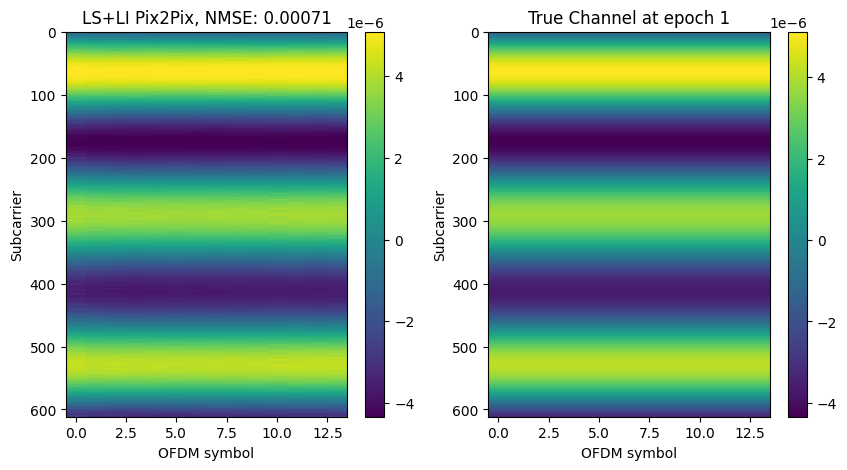

In [14]:
import matplotlib.pyplot as plt
i = 0 # epoch index

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(H_GAN_val_denormd[i,0,:,:].cpu(),  aspect='auto', cmap='viridis', interpolation='none')
plt.xlabel('OFDM symbol')
plt.ylabel('Subcarrier')
plt.title(f'LS+LI Pix2Pix, NMSE: {nmse_GAN_iSNR[i]:.5f}')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(valLabels[i,0,:,:].cpu(),  aspect='auto', cmap='viridis', interpolation='none')
plt.xlabel('OFDM symbol')
plt.ylabel('Subcarrier')
plt.title(f'True Channel at epoch {i+1}')
plt.colorbar()

plt.show()

In [15]:
# from scipy.io import loadmat
# data = loadmat(save_folder_model+'/0dB/GAN_1_variable.mat')
# print(data)

In [16]:
# from scipy.io import loadmat
# data = loadmat('../../model/static/GAN/BS16/3500_3516/ver5_nmse.mat')
# print(data)

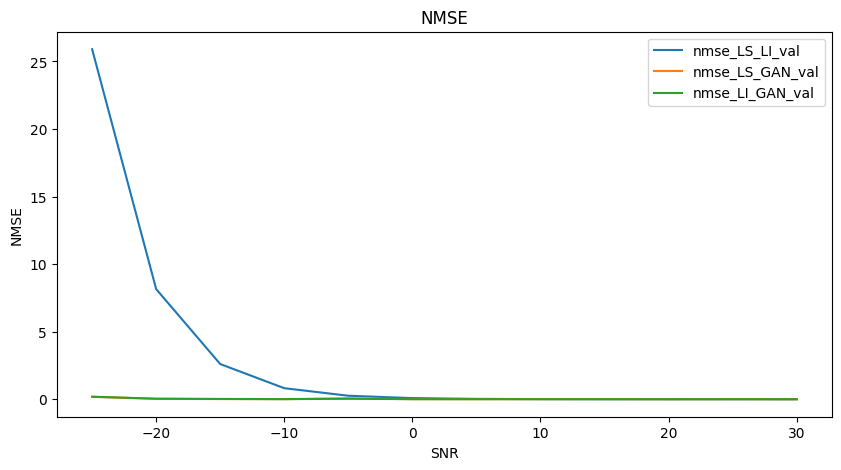

In [20]:
# 'nmse_LS_LI_val':nmse_LS_LI_val, 'nmse_LS_GAN_val':nmse_LS_GAN_val, 
#                                         'nmse_LI_GAN_val':nmse_LI_GAN_val
plt.figure(figsize=(10, 5))
plt.plot(SNR, nmse_LS_LI_val, label='LS+LI')
plt.plot(SNR, nmse_LS_GAN_val, label='LS+GAN')
plt.plot(SNR, nmse_LI_GAN_val, label='LS+LI+GAN')
plt.xlabel('SNR')
plt.ylabel('NMSE')
plt.title(f'NMSE')
plt.legend()

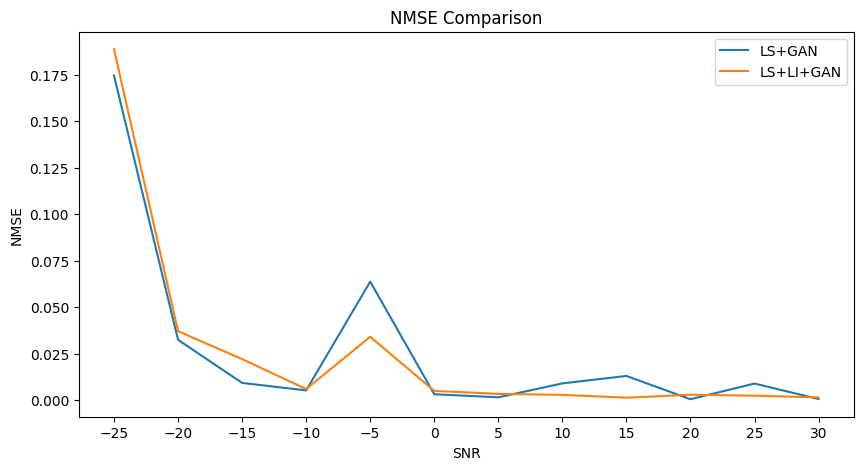

In [34]:
plt.figure(figsize=(10, 5))
plt.plot(SNR, nmse_LS_GAN_val, label='LS+GAN')
plt.plot(SNR, nmse_LI_GAN_val, label='LS+LI+GAN')
plt.xticks(SNR)
plt.xlabel('SNR')
plt.ylabel('NMSE')
plt.title(f'NMSE Comparison')
plt.legend()

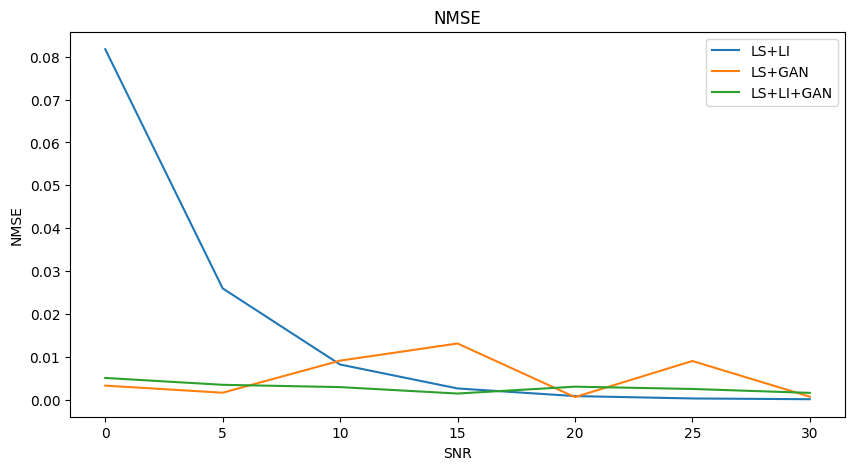

In [26]:
i=5
plt.figure(figsize=(10, 5))
plt.plot(SNR[i:], nmse_LS_LI_val[i:], label='LS+LI')
plt.plot(SNR[i:], nmse_LS_GAN_val[i:], label='LS+GAN')
plt.plot(SNR[i:], nmse_LI_GAN_val[i:], label='LS+LI+GAN')
plt.xlabel('SNR')
plt.ylabel('NMSE')
plt.title(f'NMSE')
plt.legend()

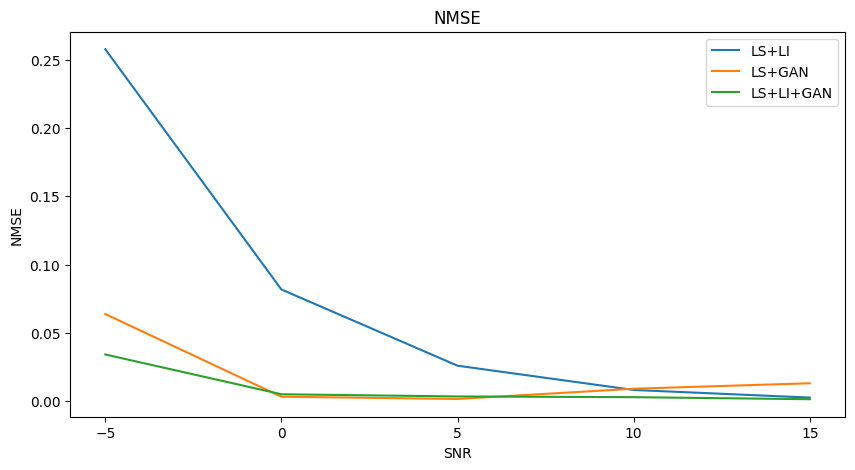

In [33]:
i=4
j=9
plt.figure(figsize=(10, 5))
plt.plot(SNR[i:j], nmse_LS_LI_val[i:j], label='LS+LI')
plt.plot(SNR[i:j], nmse_LS_GAN_val[i:j], label='LS+GAN')
plt.plot(SNR[i:j], nmse_LI_GAN_val[i:j], label='LS+LI+GAN')
plt.xticks(SNR[i:j])
plt.xlabel('SNR')
plt.ylabel('NMSE')
plt.title(f'NMSE')
plt.legend()